In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))  # increase cell width
display(
    HTML("<style>div.output_area pre {white-space: pre;}</style>")
)  # horizontal scrolling instead of newlines for printed output
%reload_ext autoreload
%autoreload 2

In [2]:
import qldpc
from qldpc import abstract, codes
import cirq
import stimcirq
import stim
import numpy as np

import sinter
import pymatching

import matplotlib.pyplot as plt

In [3]:
#noise model 
class MyNoiseModel(cirq.NoiseModel):
    def __init__(self, single_qubit_error = None, two_qubit_error = None) -> None:
        self.single_qubit_error = single_qubit_error
        self.two_qubit_error = two_qubit_error
        
    def noisy_operation(self, op: cirq.Operation) -> cirq.OP_TREE:
        if isinstance(op.gate, cirq.PauliMeasurementGate):
            return op
        if len(op.qubits) == 1:
            return [op, cirq.depolarize(self.single_qubit_error, cirq.num_qubits(op)).on(*op.qubits)]
        elif len(op.qubits) == 2:
            return [op, cirq.depolarize(self.two_qubit_error, cirq.num_qubits(op)).on(*op.qubits)]
        else: 
            raise ValueError("This circuit should be decomposed before implementing a Noise Model")

In [4]:
def get_toric_code(distance) -> codes.CSSCode:
    """Rotated toric code as a quantum Tanner code."""
    group = abstract.Group.product(abstract.CyclicGroup(distance), repeat=2)
    shift_x, shift_y = group.generators
    subset_a = [shift_x, ~shift_x]
    subset_b = [shift_y, ~shift_y]
    subcode = codes.BitCode.repetition(2)
    return codes.QTCode(subset_a, subset_b, subcode)

In [5]:
class SurfaceCode(codes.CSSCode): 
    def __init__(self, distance):
        assert distance == 3
        self.distance = distance
        code_x = np.zeros((4,9), dtype=int)
        code_z = np.zeros((4,9), dtype=int)
        
        code_z[0, 3] = 1
        code_z[0, 6] = 1
        code_z[1, 0] = 1
        code_z[1, 1] = 1
        code_z[1, 3] = 1
        code_z[1, 4] = 1
        code_z[2, 4] = 1
        code_z[2, 5] = 1
        code_z[2, 7] = 1
        code_z[2, 8] = 1
        code_z[3, 2] = 1
        code_z[3, 5] = 1

        code_x[0, 0] = 1
        code_x[0, 1] = 1
        code_x[1, 3] = 1
        code_x[1, 4] = 1
        code_x[1, 6] = 1
        code_x[1, 7] = 1
        code_x[2, 1] = 1
        code_x[2, 2] = 1
        code_x[2, 4] = 1
        code_x[2, 5] = 1
        code_x[3, 7] = 1
        code_x[3, 8] = 1
 
        codes.CSSCode.__init__(self, code_x, code_z)

In [6]:
code_x = np.zeros((4,9), dtype=int)


code_x[0, 0] = 1
code_x[0, 1] = 1
code_x[1, 3] = 1
code_x[1, 4] = 1
code_x[1, 6] = 1
code_x[1, 7] = 1
code_x[2, 1] = 1
code_x[2, 2] = 1
code_x[2, 4] = 1
code_x[2, 5] = 1
code_x[3, 7] = 1
code_x[3, 8] = 1


HGPCode = codes.HGPCode(code_x)

In [7]:
class SyndromeExtractionCircuit:
    def __init__(self, qldpc_code, error_type, single_qubit_error = 0.01, two_qubit_error = 0.01, rounds = 3, extraction_order = None) -> None:
        self.code = qldpc_code
        self.rounds = rounds
        self.error_type = error_type
        self.single_qubit_error = single_qubit_error
        self.two_qubit_error = two_qubit_error
        self.extraction_order = extraction_order
        self.ancillas= self.get_ancillas()
        self.error_ancillas = self.get_error_ancillas()
        self.data_qubits = self.get_data_qubits()
        self.qubit_index = self.get_stim_qubit_index()
        self.logical_x, self.logical_z = self.get_logical_operators()
        self.cirq_circuit = self.code_to_cirq_circuit()
        self.decomposed_cirq_circuit = self.cirq_circuit.map_operations(self.decompose_extraction_gates)
        self.noisy_circuit = self.circuit_with_noise()
        self.stim_circuit = self.code_to_stim_circuit()

        

    def insert_measurements(self, circuit):
        for qubit, pauli in self.ancillas.items():
            if pauli == self.error_type:
                circuit += [cirq.measure(cirq.NamedQubit(str(qubit))), cirq.reset(cirq.NamedQubit(str(qubit)))]
        return circuit

    
    def get_stim_qubit_index(self): #see if you can factor out total_qubits to use the specific ancillas 
        qubit_index_dict = {}
        total_qubits = [ancilla for ancilla in self.ancillas.keys()] + self.data_qubits
        for index, qubit in enumerate(total_qubits):
            qubit_index_dict[qubit] = index
            
        return qubit_index_dict
        
        
    def get_error_ancillas(self):
        return [ancilla for ancilla, pauli in self.ancillas.items() if pauli == self.error_type]
    
    def get_ancillas(self): #include option to factor out whether or not you want specific ancillas
        ancillas = {}
        if self.error_type:
            for ancilla in [qubit for qubit in sorted(self.code.graph.nodes) if not qubit.is_data]:
                for neighbor in self.code.graph.successors(ancilla):
                    ancillas[ancilla] = str(self.code.graph[ancilla][neighbor][codes.Pauli]) # a bit ugly, try to clean. only works for CSS
            
        return ancillas
    
    #use code.code_x and code.code_z to define ancillas instead of list of all neighbors
    
    
    def get_data_qubits(self):
        data_qubits = []
        for data_qubit in [qubit for qubit in sorted(self.code.graph.nodes) if qubit.is_data]:
            data_qubits.append(cirq.NamedQubit(str(data_qubit)))
        return data_qubits
    

    #use the nodes of the graph rather than the code
    
    
#     def code_to_cirq_circuit(self):
#         circuit = cirq.Circuit()
#         for ancilla, pauli in self.ancillas.items():

#             ## If error type is factored out, don't need this
#             string = {
#                 cirq.NamedQubit(str(neighbor)): pauli for neighbor in self.code.code_x.graph.successors(ancilla)
#                 }
#             circuit += cirq.H(cirq.NamedQubit(str(ancilla)))
#             circuit += cirq.PauliString(string).controlled_by(cirq.NamedQubit(str(ancilla)))
#             circuit += cirq.H(cirq.NamedQubit(str(ancilla)))
  

#         return circuit

    def code_to_cirq_circuit(self):
        circuit = cirq.Circuit()
        for ancilla, pauli in self.ancillas.items():
            if pauli == "X":
                circuit += cirq.H(cirq.NamedQubit(str(ancilla)))
                circuit += [cirq.CX(cirq.NamedQubit(str(ancilla)), cirq.NamedQubit(str(neighbor)))
                           for neighbor in self.code.graph.successors(ancilla)]
                circuit += cirq.H(cirq.NamedQubit(str(ancilla)))
            else:
                circuit += [cirq.CX(cirq.NamedQubit(str(neighbor)), cirq.NamedQubit(str(ancilla)))
                            for neighbor in self.code.graph.successors(ancilla)]
                
        return circuit
    
    
    def user_specified_extraction_circuit(self):
        stim_circuit = stim.Circuit("H", ancilla for ancilla, pauli in self.ancillas.items() if pauli == "X") #change this to X and Z ancillas 
        for cxs in self.extraction_order:
            stim_circuit.append("CX", [cxs])
            stim_circuit.append("DEPOLARIZE2", [cxs], self.two_qubit_error)
            
        return stim_circuit
    
    
    def get_logical_operators(self):
        logical_x = self.code.get_random_logical_op(codes.Pauli.X, ensure_nontrivial=True)
        logical_z = self.code.get_random_logical_op(codes.Pauli.Z, ensure_nontrivial=True)
        return logical_x, logical_z 
        

    def decompose_extraction_gates(self, op): 
        if isinstance(op, cirq.ControlledOperation) and isinstance(op.sub_operation, cirq.PauliString) and len(op.controls) == 1:
            return [pauli.on(qubit).controlled_by(*op.controls, control_values = op.control_values) for qubit , pauli in op.sub_operation.items()]
        return op 
    
    def circuit_with_noise(self):
        return cirq.align_left(self.decomposed_cirq_circuit.with_noise
                               (MyNoiseModel(self.single_qubit_error, self.two_qubit_error)))
    
    
    def code_to_stim_circuit(self): 
        stim_circuit = stim.Circuit()
        ancillas = [ancilla for ancilla in self.ancillas.keys()] #changed 
        stim_circuit.append("R" + self.error_type, [self.qubit_index[data_qubit] for data_qubit in self.data_qubits]) 
        stim_circuit.append("R", [self.qubit_index[ancilla] for ancilla in ancillas])        
        
        if self.extraction_order:
            stim_circuit += user_specified_extraction
    
        
        stim_circuit += stimcirq.cirq_circuit_to_stim_circuit(self.noisy_circuit)
        
        
        stim_circuit.append("X_ERROR", [self.qubit_index[ancilla] for ancilla in ancillas], self.single_qubit_error)
        
        measurement_dictionary = {}
        counter = -len(ancillas)
        
        for ancilla in ancillas:
            measurement_dictionary[self.qubit_index[ancilla]] = counter
            counter = counter + 1
            stim_circuit.append("MR", [self.qubit_index[ancilla]])
        
        rounds_circuit = stim_circuit[4:]
        rounds_circuit.append("X_ERROR", [self.qubit_index[ancilla] for ancilla in ancillas], self.single_qubit_error)
        rounds_circuit.append("SHIFT_COORDS", [], [0,0,1])
        
        stim_circuit.append("X_ERROR", [self.qubit_index[ancilla] for ancilla in ancillas], self.single_qubit_error)
                
        for ancilla in self.error_ancillas:
            stim_circuit.append("DETECTOR", stim.target_rec(measurement_dictionary[self.qubit_index[ancilla]]))
                
        for i in range(1, len(ancillas) + 1 , 1):
            rounds_circuit.append("DETECTOR", (stim.target_rec(-i), stim.target_rec(-i - len(ancillas))))

            
        #choosing the logical operator
        if self.error_type == "Z":
            logical_operator = self.logical_x
            measurement = "M"
        elif self.error_type == "X":
            logical_operator = self.logical_z
            measurement = "MX" #try MX for the X type
                                    
        observable_circuit = stim.Circuit()
        observable_dictionary = {}
        counter = -len(self.data_qubits)
        
        observable_circuit.append("X_ERROR", [self.qubit_index[data_qubit] for data_qubit in self.data_qubits], self.single_qubit_error)        
        for data_qubit in self.data_qubits:
            observable_dictionary[self.qubit_index[data_qubit]] = counter
            counter = counter + 1
            observable_circuit.append(measurement, [self.qubit_index[data_qubit]])
        
        for ancilla in self.error_ancillas:
            ancilla_index = [-len(self.data_qubits) - ancillas[::-1].index(ancilla) - 1]
            neighbor_indices = [-self.data_qubits[::-1].index(cirq.NamedQubit(str(data_qubit)))-1 
                                for data_qubit in self.code.graph.successors(ancilla)]
            total_detection = ancilla_index + neighbor_indices
            observable_circuit.append("DETECTOR", [stim.target_rec(i) for i in total_detection])
            
        observable_include = [stim.target_rec(observable_dictionary[self.qubit_index[qubit]]) 
                              for observable, qubit in zip(logical_operator, self.data_qubits) if observable == 1]
        
        observable_circuit.append("OBSERVABLE_INCLUDE", observable_include, 0)
        return stim_circuit + (rounds_circuit * (self.rounds-1)) + observable_circuit 



    
###X TYPE CELL

In [8]:
bit_code = codes.ClassicalCode.repetition(3)
code = codes.HGPCode(bit_code)


circuit = SyndromeExtractionCircuit(code, "X", rounds = 1).stim_circuit

circuit

stim.Circuit('''
    RX 12 13 14 15 16 17 18 19 20 21 22 23 24
    Z_ERROR(0.01) 0 1 2 3 4 5 6 7 8 9 10 11
    R 0 1 2 3 4 5 6 7 8 9 10 11
    X_ERROR(0.01) 12 13 14 15 16 17 18 19 20 21 22 23 24
    H 0 1 2 3
    DEPOLARIZE1(0.01) 0 1 2 3
    CX 0 11 2 13 1 9 16 7 12 5 10 6
    DEPOLARIZE2(0.01) 0 11 2 13 1 9 16 7 12 5 10 6
    CX 0 14 2 16 1 12 15 7 11 5 9 6
    DEPOLARIZE2(0.01) 0 14 2 16 1 12 15 7 11 5 9 6
    CX 2 12 1 8 3 10 15 5 13 6 9 4
    DEPOLARIZE2(0.01) 2 12 1 8 3 10 15 5 13 6 9 4
    CX 2 15 1 11 3 13 14 5 12 6 8 4
    DEPOLARIZE2(0.01) 2 15 1 11 3 13 14 5 12 6 8 4
    H 0 1 2 3
    DEPOLARIZE1(0.01) 0 1 2 3
    X_ERROR(0.01) 0 1 2 3 4 5 6 7 8 9 10 11
    MR 0 1 2 3 4 5 6 7 8 9 10 11
    X_ERROR(0.01) 0 1 2 3 4 5 6 7 8 9 10 11
    DETECTOR rec[-12]
    DETECTOR rec[-11]
    DETECTOR rec[-10]
    DETECTOR rec[-9]
    DETECTOR rec[-8]
    DETECTOR rec[-7]
    X_ERROR(0.01) 12 13 14 15 16 17 18 19 20 21 22 23 24
    MX 12 13 14 15 16 17 18 19 20 21 22 23 24
    DETECTOR rec[

In [9]:
p_min = -5
p_max = -1
num_points = 10
rounds = 3 

distance = 3
# bit_code = codes.ClassicalCode.repetition(3)
# code = codes.HGPCode(bit_code)

code = SurfaceCode(distance)


code_tasks = [
    sinter.Task(
        circuit = SyndromeExtractionCircuit(code, "X", noise, noise, rounds=rounds).stim_circuit,
        json_metadata={'d': 3, 'r': rounds, 'p': noise},
    )
    for noise in np.logspace(p_min,p_max, num_points)
]

collected_surface_code_stats = sinter.collect(
    num_workers=4,
    tasks=code_tasks,
    decoders=['pymatching'],
    max_shots=1_000_000,
    max_errors=5000,
    print_progress=True,
)

###############################################################################

Starting 4 workers...
Done collecting


0 1000000
physical error rate: 1e-05 logical error rate: 0.0 distance: 3
0 1000000
physical error rate: 2.782559402207126e-05 logical error rate: 0.0 distance: 3
0 1000000
physical error rate: 7.742636826811278e-05 logical error rate: 0.0 distance: 3
13 1000000
physical error rate: 0.00021544346900318823 logical error rate: 1.3e-05 distance: 3
109 1000000
physical error rate: 0.0005994842503189409 logical error rate: 0.000109 distance: 3
772 1000000
physical error rate: 0.0016681005372000592 logical error rate: 0.000772 distance: 3
5003 870181
physical error rate: 0.004641588833612777 logical error rate: 0.005749378577560301 distance: 3
5034 128775
physical error rate: 0.012915496650148827 logical error rate: 0.03909143855562027 distance: 3
5002 25787
physical error rate: 0.03593813663804626 logical error rate: 0.19397370768216543 distance: 3
5095 11331
physical error rate: 0.1 logical error rate: 0.44965139881740357 distance: 3


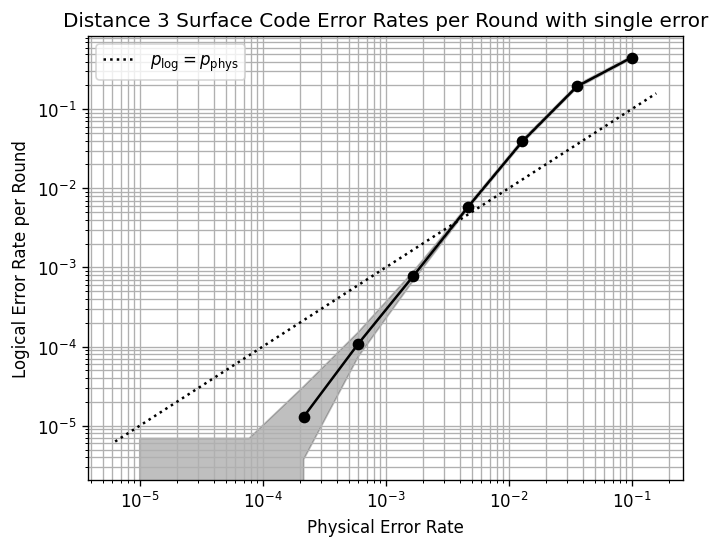

In [10]:
fig,ax = plt.subplots(1,1)

sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats,
    x_func=lambda stats: stats.json_metadata['p'],
#     group_func = lambda stats: stats.json_metadata['d'],
#     failure_units_per_shot_func = lambda stats: stats.json_metadata['r'],

)

prob_vals = np.logspace(p_min,p_max, num_points)
error_vals = np.zeros((num_points, num_points))
shot_vals = np.empty_like(error_vals)


for stat in collected_surface_code_stats:
    error = stat.json_metadata["p"]
    distance = stat.json_metadata["d"]
    stat_index = (list(prob_vals).index(error))
    error_vals[stat_index] = stat.errors
    shot_vals[stat_index] = stat.shots
    print(stat.errors, stat.shots)
    print("physical error rate:", error, "logical error rate:" ,stat.errors/stat.shots, "distance:", distance)



ax.loglog()
ref_min = max(ax.get_xlim()[0], ax.get_ylim()[0])
ref_max = min(ax.get_xlim()[1], ax.get_ylim()[1])
ax.plot([ref_min, ref_max], [ref_min, ref_max], "k:", label=r"$p_{\mathrm{log}}=p_{\mathrm{phys}}$")
ax.set_title(f"Distance 3 Surface Code Error Rates per Round with single error")
ax.set_xlabel("Physical Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120) 

In [9]:
### using the stim package to graph
surface_code_circuit = stim.Circuit.generated(
    "surface_code:unrotated_memory_x",
    rounds=3,
    distance=3,
    after_clifford_depolarization=0.01,
    after_reset_flip_probability=0.01,
    before_measure_flip_probability=0.01,
    before_round_data_depolarization=0.01)

# cirq_circuit = stimcirq.stim_circuit_to_cirq_circuit(surface_code_circuit)
# print(cirq_circuit)


In [10]:
p_min = -5
p_max = -1
num_points = 10
rounds = 3

surface_code_tasks = [
    sinter.Task(
        circuit = stim.Circuit.generated(
            "surface_code:unrotated_memory_x",
            rounds=d,
            distance=d,
            after_clifford_depolarization=noise,
            after_reset_flip_probability=noise,
            before_measure_flip_probability=noise,
            before_round_data_depolarization=noise,
        ),
        json_metadata={'d': d, 'r': d, 'p': noise},
    )
    for d in [3]
    for noise in np.logspace(p_min,p_max, num_points)
]

collected_surface_code_stats = sinter.collect(
    num_workers=4,
    tasks=surface_code_tasks,
    decoders=['pymatching'],
    max_shots=1_000_000,
    max_errors=5000,
    print_progress=True,
)

Starting 4 workers...
Done collecting


0 1000000
physical error rate: 1e-05 logical error rate: 0.0 distance: 3
0 1000000
physical error rate: 2.782559402207126e-05 logical error rate: 0.0 distance: 3
35 1000000
physical error rate: 0.00021544346900318823 logical error rate: 3.5e-05 distance: 3
2 1000000
physical error rate: 7.742636826811278e-05 logical error rate: 2e-06 distance: 3
332 1000000
physical error rate: 0.0005994842503189409 logical error rate: 0.000332 distance: 3
2496 1000000
physical error rate: 0.0016681005372000592 logical error rate: 0.002496 distance: 3
5028 279309
physical error rate: 0.004641588833612777 logical error rate: 0.018001568155698526 distance: 3
5004 44719
physical error rate: 0.012915496650148827 logical error rate: 0.11189874549967575 distance: 3
5092 13567
physical error rate: 0.03593813663804626 logical error rate: 0.3753224736492961 distance: 3
5068 9985
physical error rate: 0.1 logical error rate: 0.5075613420130195 distance: 3


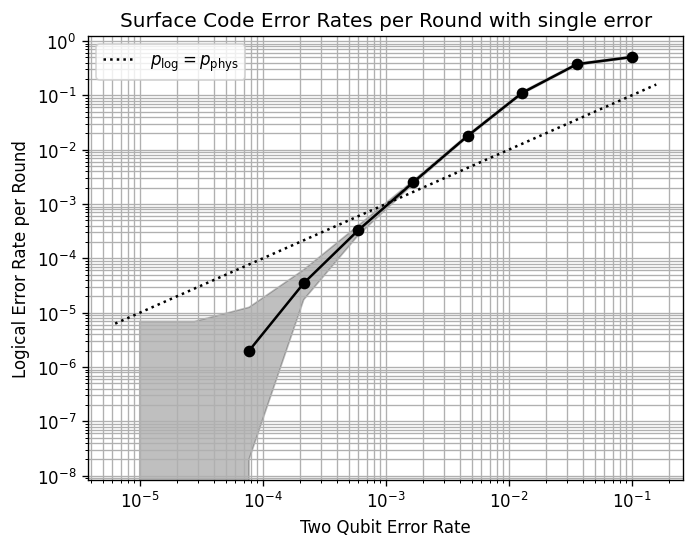

In [11]:
fig,ax = plt.subplots(1,1)

x_func = np.logspace(p_min, p_max, num_points)

sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats,
    x_func=lambda stats: stats.json_metadata['p'],
#     group_func = lambda stats: stats.json_metadata['d'],
#     failure_units_per_shot_func = lambda stats: stats.json_metadata['r'],

)

prob_vals = np.logspace(p_min,p_max, num_points)
error_vals = np.zeros((num_points, num_points))
shot_vals = np.empty_like(error_vals)


for stat in collected_surface_code_stats:
    error = stat.json_metadata["p"]
    distance = stat.json_metadata["d"]
    stat_index = (list(prob_vals).index(error))
    error_vals[stat_index] = stat.errors
    shot_vals[stat_index] = stat.shots
    print(stat.errors, stat.shots)
    print("physical error rate:", error, "logical error rate:" ,stat.errors/stat.shots, "distance:", distance)



ax.loglog()
ref_min = max(ax.get_xlim()[0], ax.get_ylim()[0])
ref_max = min(ax.get_xlim()[1], ax.get_ylim()[1])
ax.plot([ref_min, ref_max], [ref_min, ref_max], "k:", label=r"$p_{\mathrm{log}}=p_{\mathrm{phys}}$")
ax.set_title(f"Surface Code Error Rates per Round with single error")
ax.set_xlabel("Two Qubit Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120) 

In [195]:
surface_code_circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=3,
    distance=3,
    after_clifford_depolarization=0.01,
    after_reset_flip_probability=0.01,
    before_measure_flip_probability=0.01,
    before_round_data_depolarization=0.01)


print(surface_code_circuit)

QUBIT_COORDS(1, 1) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 1) 3
QUBIT_COORDS(5, 1) 5
QUBIT_COORDS(1, 3) 8
QUBIT_COORDS(2, 2) 9
QUBIT_COORDS(3, 3) 10
QUBIT_COORDS(4, 2) 11
QUBIT_COORDS(5, 3) 12
QUBIT_COORDS(6, 2) 13
QUBIT_COORDS(0, 4) 14
QUBIT_COORDS(1, 5) 15
QUBIT_COORDS(2, 4) 16
QUBIT_COORDS(3, 5) 17
QUBIT_COORDS(4, 4) 18
QUBIT_COORDS(5, 5) 19
QUBIT_COORDS(4, 6) 25
R 1 3 5 8 10 12 15 17 19
X_ERROR(0.01) 1 3 5 8 10 12 15 17 19
R 2 9 11 13 14 16 18 25
X_ERROR(0.01) 2 9 11 13 14 16 18 25
TICK
DEPOLARIZE1(0.01) 1 3 5 8 10 12 15 17 19
H 2 11 16 25
DEPOLARIZE1(0.01) 2 11 16 25
TICK
CX 2 3 16 17 11 12 15 14 10 9 19 18
DEPOLARIZE2(0.01) 2 3 16 17 11 12 15 14 10 9 19 18
TICK
CX 2 1 16 15 11 10 8 14 3 9 12 18
DEPOLARIZE2(0.01) 2 1 16 15 11 10 8 14 3 9 12 18
TICK
CX 16 10 11 5 25 19 8 9 17 18 12 13
DEPOLARIZE2(0.01) 16 10 11 5 25 19 8 9 17 18 12 13
TICK
CX 16 8 11 3 25 17 1 9 10 18 5 13
DEPOLARIZE2(0.01) 16 8 11 3 25 17 1 9 10 18 5 13
TICK
H 2 11 16 25
DEPOLARIZE1(0.01) 2 11 16 25
TICK
X_ERROR(0.

In [196]:
surface_code_circuit.diagram()

/---------------------------------------------\ /---------------------------------\ /-----------------\ /-------------------------------------------------------------------------\ /---------------------------------------------------------\ /-----------------------------------------------------------------------------\ /-----------------\ /-------------------------------------------------------------\ /REP 2   /---------------------------------\ /-----------------\ /-------------------------------------------------------------------------\ /---------------------------------------------------------\ /-----------------------------------------------------------------------------\ /-----------------\ /----------------------------------------------------------------------------------------------------------\ \ /----------------------------------------------------------------------------------------------------------------------\
 q0: ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------
                                                                                                                                                                                                                                                                                                                                                                                                                          |                                                                                                                                                                                                                                                                                                                                                                                                                         |
 q1: -QUBIT_COORDS(1,1)-R-X_ERROR(0.01)---------------DEPOLARIZE1(0.01)---------------------------------------X---DEPOLARIZE2(0.01)-----------------------------------------------------------------------------------------------------------------------@---------------------------------------DEPOLARIZE2(0.01)-------------------------------------------------------------------------------------------------------|--------DEPOLARIZE1(0.01)---------------------------------------X---DEPOLARIZE2(0.01)-----------------------------------------------------------------------------------------------------------------------@---------------------------------------DEPOLARIZE2(0.01)----------------------------------------------------------------------------------------------------------------------------------------------------|-X_ERROR(0.01)-M:rec[24]---------------------------------------------------OBSERVABLE_INCLUDE:L0*=rec[26]*rec[25]*rec[24]-
                                                                                                              |   |                                                                                                                                       |                                       |                                                              

In [ ]:
       stim_circuit.append("R" + self.error_type, [self.qubit_index[data_qubit] for data_qubit in self.data_qubits]) 
        stim_circuit.append("Z_ERROR", [self.qubit_index[ancilla] for ancilla in ancillas], self.single_qubit_error)        
        stim_circuit.append("R", [self.qubit_index[ancilla] for ancilla in ancillas])        
        stim_circuit.append("X_ERROR", [self.qubit_index[data_qubit] for data_qubit in self.data_qubits], self.single_qubit_error)
        stim_circuit.append("H", [0, 1, 2, 3])
        stim_circuit.append("DEPOLARIZE1", [0,1,2,3], self.single_qubit_error)
        stim_circuit.append("CX", [0,11, 2, 13, 1, 9, 16, 7, 12, 5, 10, 6])
        stim_circuit.append("DEPOLARIZE2", [0,11, 2, 13, 1, 9, 16, 7, 12, 5, 10, 6], self.two_qubit_error)
        stim_circuit.append("CX", [0, 14, 2, 16, 1, 12, 15, 7, 11, 5, 9, 6])
        stim_circuit.append("DEPOLARIZE2", [0, 14, 2, 16, 1, 12, 15, 7, 11, 5, 9, 6], self.two_qubit_error) 
        stim_circuit.append("CX", [2, 12, 1, 8, 3, 10, 15, 5, 13, 6, 9, 4])
        stim_circuit.append("DEPOLARIZE2", [2, 12, 1, 8, 3, 10, 15, 5, 13, 6, 9, 4], self.two_qubit_error)
        stim_circuit.append("CX", [2, 15, 1, 11, 3, 13, 14, 5, 12, 6, 8, 4])
        stim_circuit.append("DEPOLARIZE2", [2, 15, 1, 11, 3, 13, 14, 5, 12, 6, 8, 4], self.two_qubit_error)
        stim_circuit.append("H", [0,1,2,3])
        stim_circuit.append("DEPOLARIZE1", [0,1,2,3], self.single_qubit_error)